# Fingerprint-based similarity scores - exploring log scaling and IDF

## Challenge
1. The commonly used fingerprints (Morgan, rdkit etc.) all count every bit equally, no matter how rare or common the underlying structure is.
2. Count vectors *can* have the tendency to "over-react" on some smaller bits that might occur in very high numbers (such as a "-C-" sequence in lipids).

## Data

Here we use the **ms2structures dataset** containing 37,811 unique compounds.

In [7]:
import os
import sys
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [3]:
filename = "compounds_ms2structures.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [4]:
def idf_normalized(df, N):
    def formula(x, N):
        return np.log(N / x)

    max_idf = formula(1, N)
    return formula(df, N) / max_idf

In [5]:
# Add source code path
sys.path.insert(0, os.path.join(ROOT, "src"))

# Import funtion/classes from source code
from fingerprint_computation import FingerprintGenerator, SparseFingerprintGenerator, compute_fingerprints_from_smiles
from metrics import ruzicka_similarity_matrix_sparse, jaccard_similarity_matrix_sparse

In [11]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fingerprints_morgan3_sparse = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=False, sparse=True, progress_bar=True
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:05<00:00, 6475.69it/s]


# Count fingerprint bits

In [9]:
from fingerprint_computation import count_fingerprint_keys

In [12]:
%%time

unique_keys, counts, first_instances = count_fingerprint_keys(fingerprints_morgan3_sparse)

/home/daisy/Florian/molecular_fingerprint_comparisons/src/fingerprint_computation.py:193: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  counts[bit] += 1


CPU times: user 947 ms, sys: 16 ms, total: 963 ms
Wall time: 971 ms


In [13]:
unique_keys.shape, counts.shape, first_instances.shape

((287577,), (287577,), (287577,))

In [14]:
counts.max(), counts.min()

(np.int32(31788), np.int32(1))

In [15]:
# Counts == 1 could later be discarded!
(counts == 1).sum()

np.int64(175954)

In [16]:
(counts <= 2).sum()

np.int64(218485)

In [22]:
idf_normalized(np.arange(1, 11), 37811)

array([1.        , 0.93423873, 0.89577085, 0.86847745, 0.84730705,
       0.83000958, 0.81538477, 0.80271618, 0.7915417 , 0.78154578])

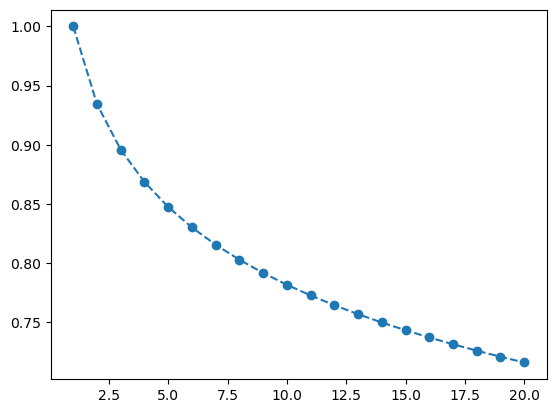

In [30]:
plt.plot(np.arange(1, 21), idf_normalized(np.arange(1, 21), 37811), "o--")

In [31]:
idx = np.where(counts > 1)[0]
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
})

,bit,count
0,34552,3
1,79728,7
2,93098,2
3,96188,7
4,115440,4
...,...,...
111618,4294701792,2
111619,4294707339,8
111620,4294751024,2
111621,4294767870,4


In [32]:
num_compounds = len(fingerprints_morgan3_sparse)

idx = np.where(counts > 1)[0]
bit_weighing = {unique_keys[i]: idf_normalized(counts[i], num_compounds) for i in idx}

In [33]:
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
}).to_csv("bit_counts_ms2structures_morgan3.csv")

In [34]:
pd.DataFrame({
    "bit": list(bit_weighing.keys()),
    "idf_weighing": list(bit_weighing.values())
}).set_index("bit").to_csv("bit_weighing_ms2structures_morgan3.csv")

## Inspect the most common bits

In [35]:
def get_substructure_smiles(mol, atom_idx, radius):
    if radius == 0:
        # Create a single-atom submolecule for radius=0
        atom = mol.GetAtomWithIdx(atom_idx)
        submol = Chem.RWMol(Chem.Mol())
        new_idx = submol.AddAtom(atom)
        amap = {atom_idx: new_idx}
        subsmiles = Chem.MolToSmiles(submol)
    else:
        # Get the atom environment for the given radius
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
        if not env:
            return None  # Handle cases where no environment is found
        amap = {}
        submol = Chem.PathToSubmol(mol, env, atomMap=amap)
        #display(submol)
        #Chem.Kekulize(submol)
        subsmiles = Chem.MolToSmiles(submol, allBondsExplicit=True, allHsExplicit=True)
        #subsmiles = Chem.MolToSmiles(submol)
    return subsmiles

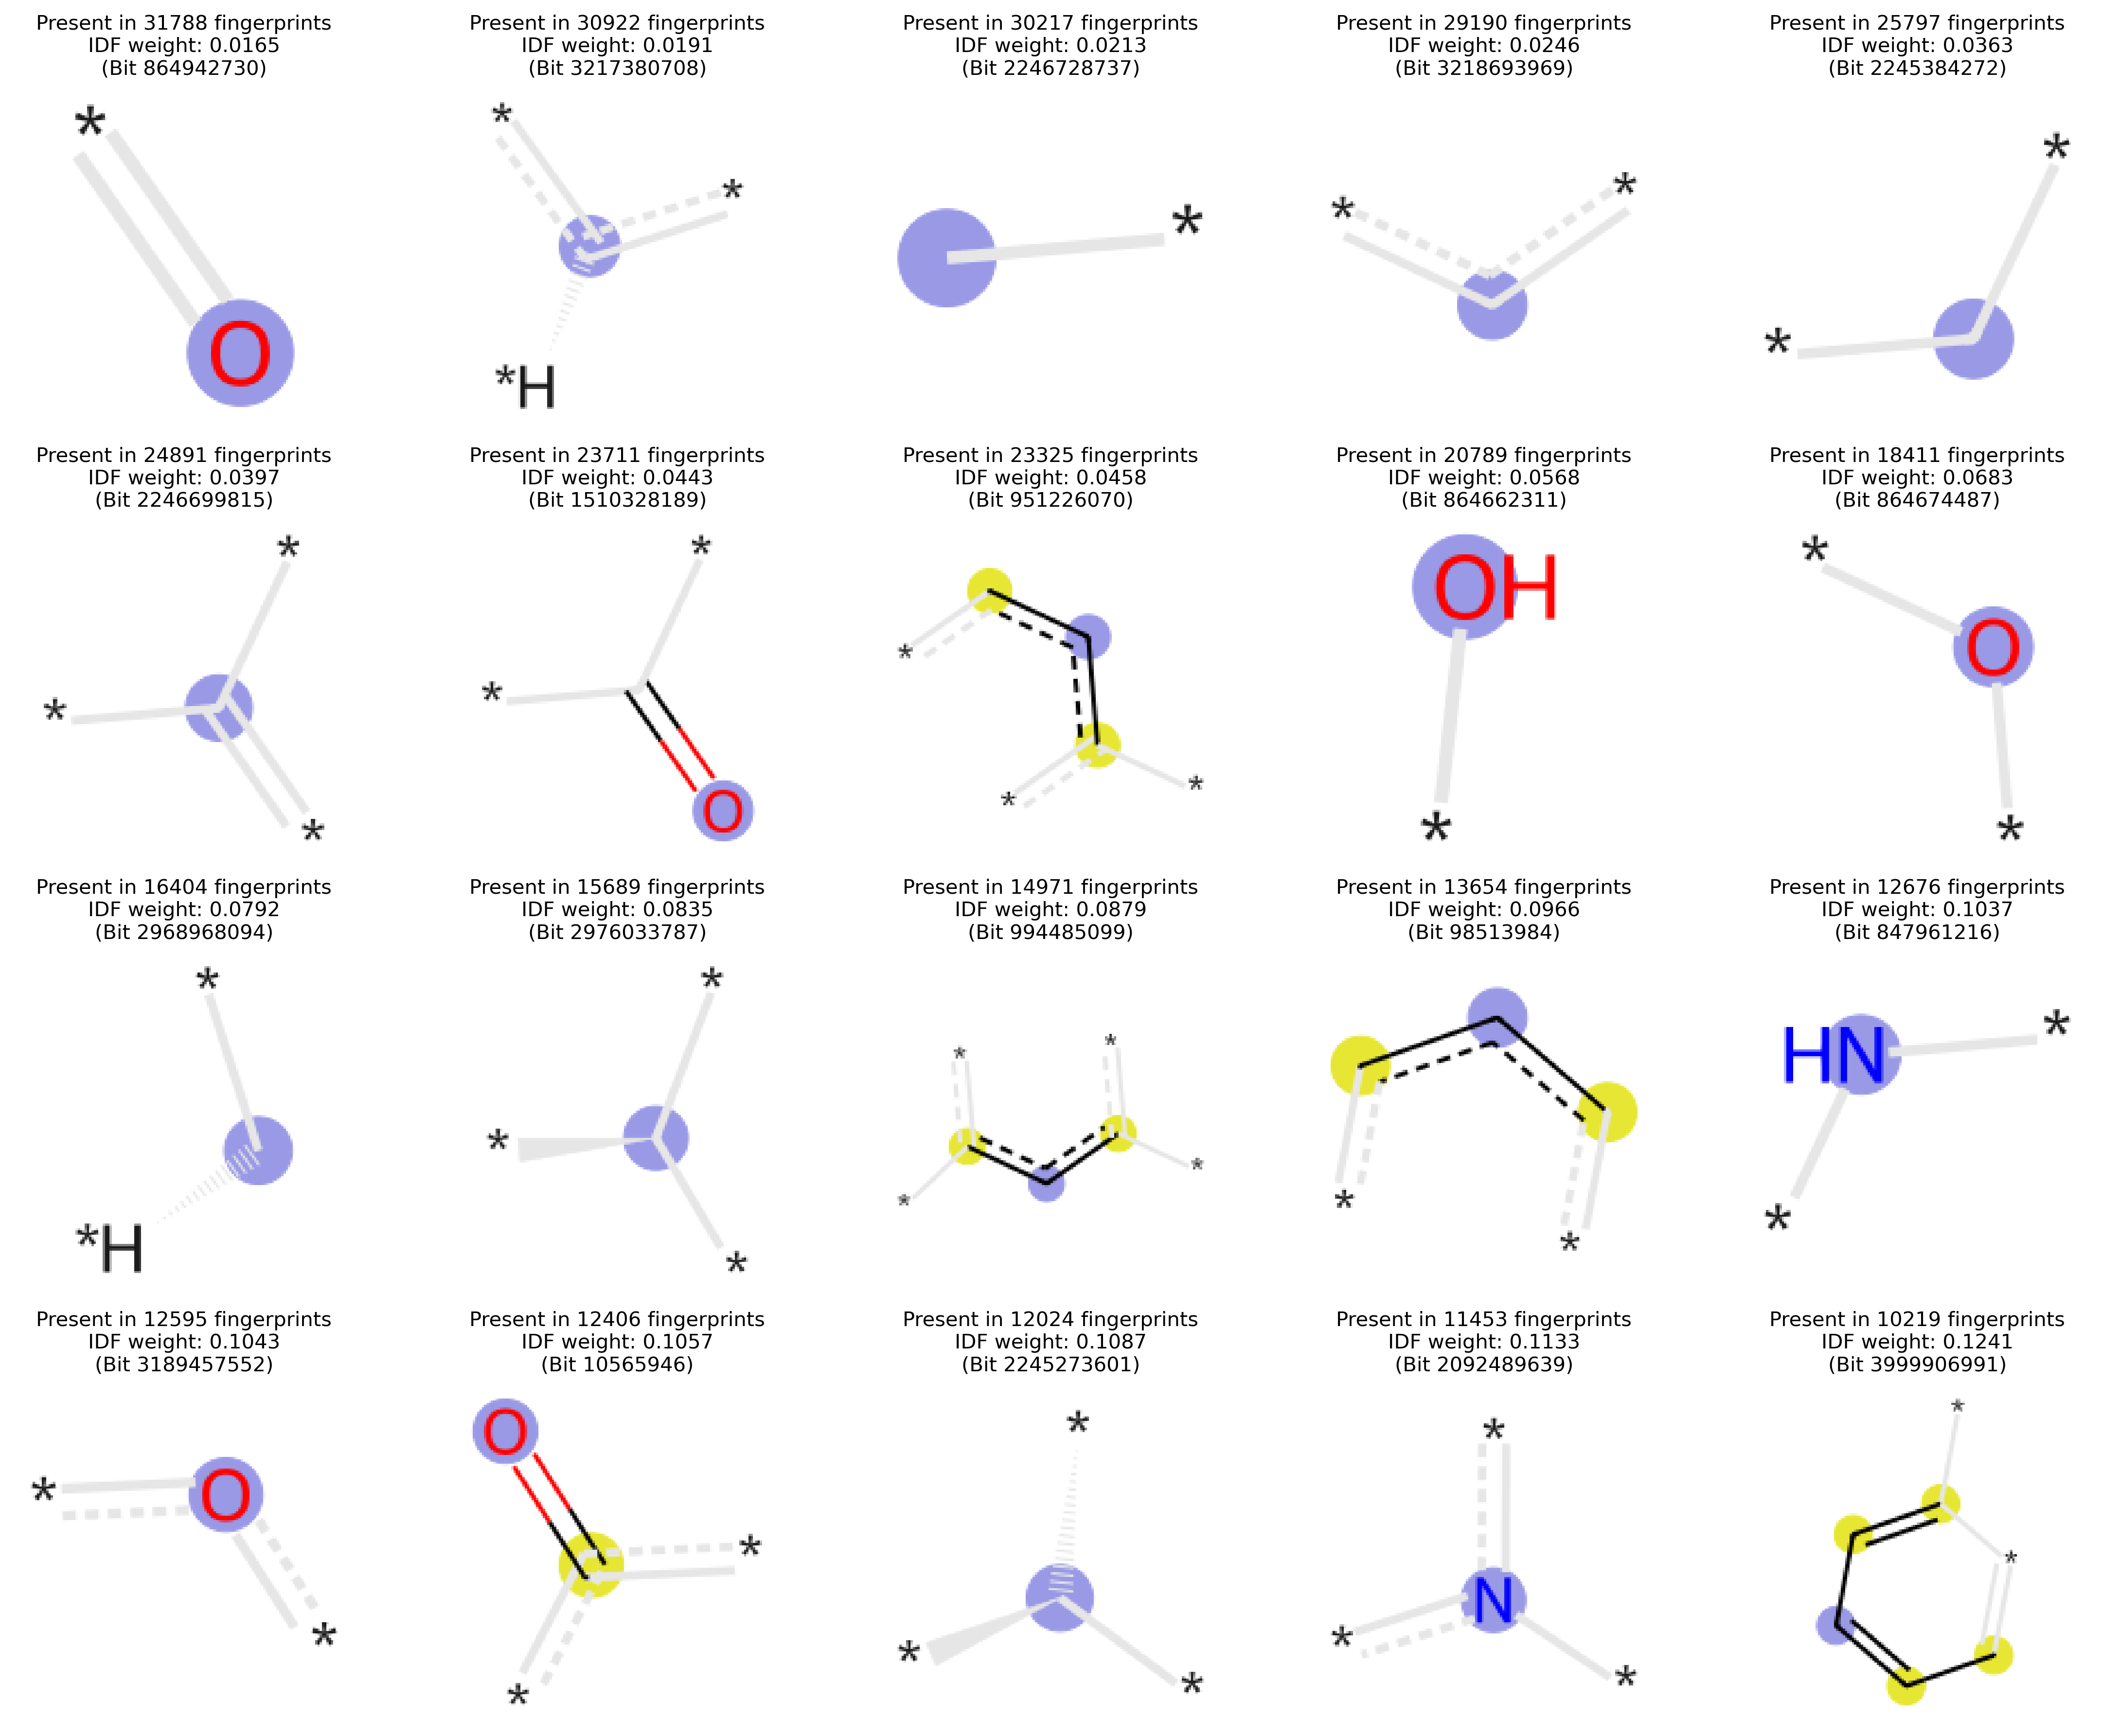

In [36]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import AllChem
import pandas as pd

# Assuming `unique_keys`, `idx_sorted`, `counts`, `compounds`, `fingerprints`, and helper functions are already defined
fpgen = AllChem.GetMorganGenerator(radius=3)

# Initialize data storage for frequent bits
frequent_bits = {
    "counts": [],
    "radius": [],
    "subsmiles": [],
    "bit_id": [],
    "mol_images": [],
}
mol_svgs = []
images = []

idx_sorted = np.argsort(counts)[::-1]


# Process top 20 bits
for i, idx in enumerate(idx_sorted[:20]):
    smiles = compounds.smiles[first_instances[idx]]
    mol = Chem.MolFromSmiles(smiles)

    ao = AllChem.AdditionalOutput()
    ao.CollectBitInfoMap()
    fp = fpgen.GetSparseCountFingerprint(mol, additionalOutput=ao)
    bi = ao.GetBitInfoMap()

    if unique_keys[idx] in bi:
        atom_idx, radius = bi[unique_keys[idx]][0]
        frequent_bits["counts"].append(counts[idx])
        frequent_bits["radius"].append(radius)
        frequent_bits["bit_id"].append(unique_keys[idx])
        
        # Generate substructure SMILES
        if radius == 0:
            subsmiles0 = get_substructure_smiles(mol, atom_idx, 0)
            subsmiles1 = get_substructure_smiles(mol, atom_idx, 1)
            frequent_bits["subsmiles"].append(subsmiles0 + " <-- " + subsmiles1)
        else:
            frequent_bits["subsmiles"].append(get_substructure_smiles(mol, atom_idx, radius))

        # Generate image of molecule with highlighted bit
        img = Draw.DrawMorganBit(mol, unique_keys[idx], bi)#, useSVG=True)
        images.append((mol, unique_keys[idx], bi))
        frequent_bits["mol_images"].append(img)
        #mol_svgs.append(img)

# Convert data to DataFrame
frequent_bits_df = pd.DataFrame(frequent_bits)
frequent_bits_df["idf_weight"] = idf_normalized(frequent_bits_df["counts"], len(fingerprints_morgan3_sparse))

# Create grid plot
n_cols = 5
n_rows = (len(frequent_bits_df) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3), dpi=300)

legends = []

for i, ax in enumerate(axes.flatten()):
    if i < len(frequent_bits_df):
        ax.imshow(frequent_bits_df.loc[i, "mol_images"])
        legend = f"Present in {frequent_bits_df.loc[i, 'counts']} fingerprints\nIDF weight: {frequent_bits_df.loc[i, 'idf_weight']:.4f}\n(Bit {frequent_bits_df.loc[i, 'bit_id']})"
        legends.append(legend)
        ax.set_title(legend, fontsize=10)
    ax.axis("off")

plt.tight_layout()
#plt.savefig("most_frequent_bits_Morgan3.png", dpi=300)
plt.show()

## Morgan-9

In [37]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096)

fingerprints_morgan9_sparse = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=False, sparse=True, progress_bar=True
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37811/37811 [00:08<00:00, 4240.21it/s]


In [38]:
%%time

unique_keys, counts, first_instances = count_fingerprint_keys(fingerprints_morgan9_sparse)

CPU times: user 507 ms, sys: 32 ms, total: 539 ms
Wall time: 539 ms


In [39]:
unique_keys.shape, counts.shape, first_instances.shape, counts.max(), counts.min()

((1074917,), (1074917,), (1074917,), np.int32(31788), np.int32(1))

In [40]:
idx = np.where(counts > 1)[0]
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
}).to_csv("bit_counts_ms2structures_morgan9.csv")

In [41]:
num_compounds = len(fingerprints_morgan9_sparse)

idx = np.where(counts > 1)[0]
bit_weighing = {unique_keys[i]: idf_normalized(counts[i], num_compounds) for i in idx}

In [42]:
pd.DataFrame({
    "bit": list(bit_weighing.keys()),
    "idf_weighing": list(bit_weighing.values())
}).set_index("bit").to_csv("bit_weighing_ms2structures_morgan9.csv")

# Now run this on the biostructures dataset!

In [44]:
filename = "biostructures_combined.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))

print(compounds.shape)
compounds.head()

(730464, 1)


,smiles
0,C1CCCC(CC1)CCCCCNCCSS(=O)(=O)O
1,CC1=CC2=C(C3=C(CCC3)C(=O)O2)C(=C1)OC4C(C(C(C(O...
2,C1=CC(=CC(=C1)Br)C(=O)NCC(=O)NN=CC2=C(C=C(C=C2...
3,COC(=O)CC(C1=CC=CC=C1)C2=C(C=C(C3=C2OC(=CC3=O)...
4,CC1C(OC(CC1=C)(C(C(=O)NC2C3C(C(C(C(O3)CC(CO)OC...


In [45]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fingerprints_morgan3_biostructures = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=False, sparse=True, progress_bar=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 730464/730464 [02:08<00:00, 5672.45it/s]


In [58]:
%%time

unique_keys, counts, first_instances = count_fingerprint_keys(fingerprints_morgan3_biostructures)#, max_keys=10**8)

CPU times: user 4.74 s, sys: 70 ms, total: 4.81 s
Wall time: 4.81 s


In [59]:
unique_keys.shape, counts.shape, first_instances.shape

((2259990,), (2259990,), (2259990,))

In [60]:
counts.max()

np.int32(589593)

In [61]:
idx = np.where(counts > 1)[0]
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
})

,bit,count
0,368,10
1,676,4
2,1040,2
3,9403,2
4,13347,6
...,...,...
997952,4294947328,2
997953,4294949385,3
997954,4294957949,4
997955,4294958106,6


In [62]:
pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx]
}).to_csv("bit_counts_biostructures_morgan3.csv")

In [63]:
idx = np.where(counts > 1)[0]

pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx],
    "first_instance": first_instances[idx]
}).to_csv("bit_counts_biostructures_morgan3_w_first_instance.csv")

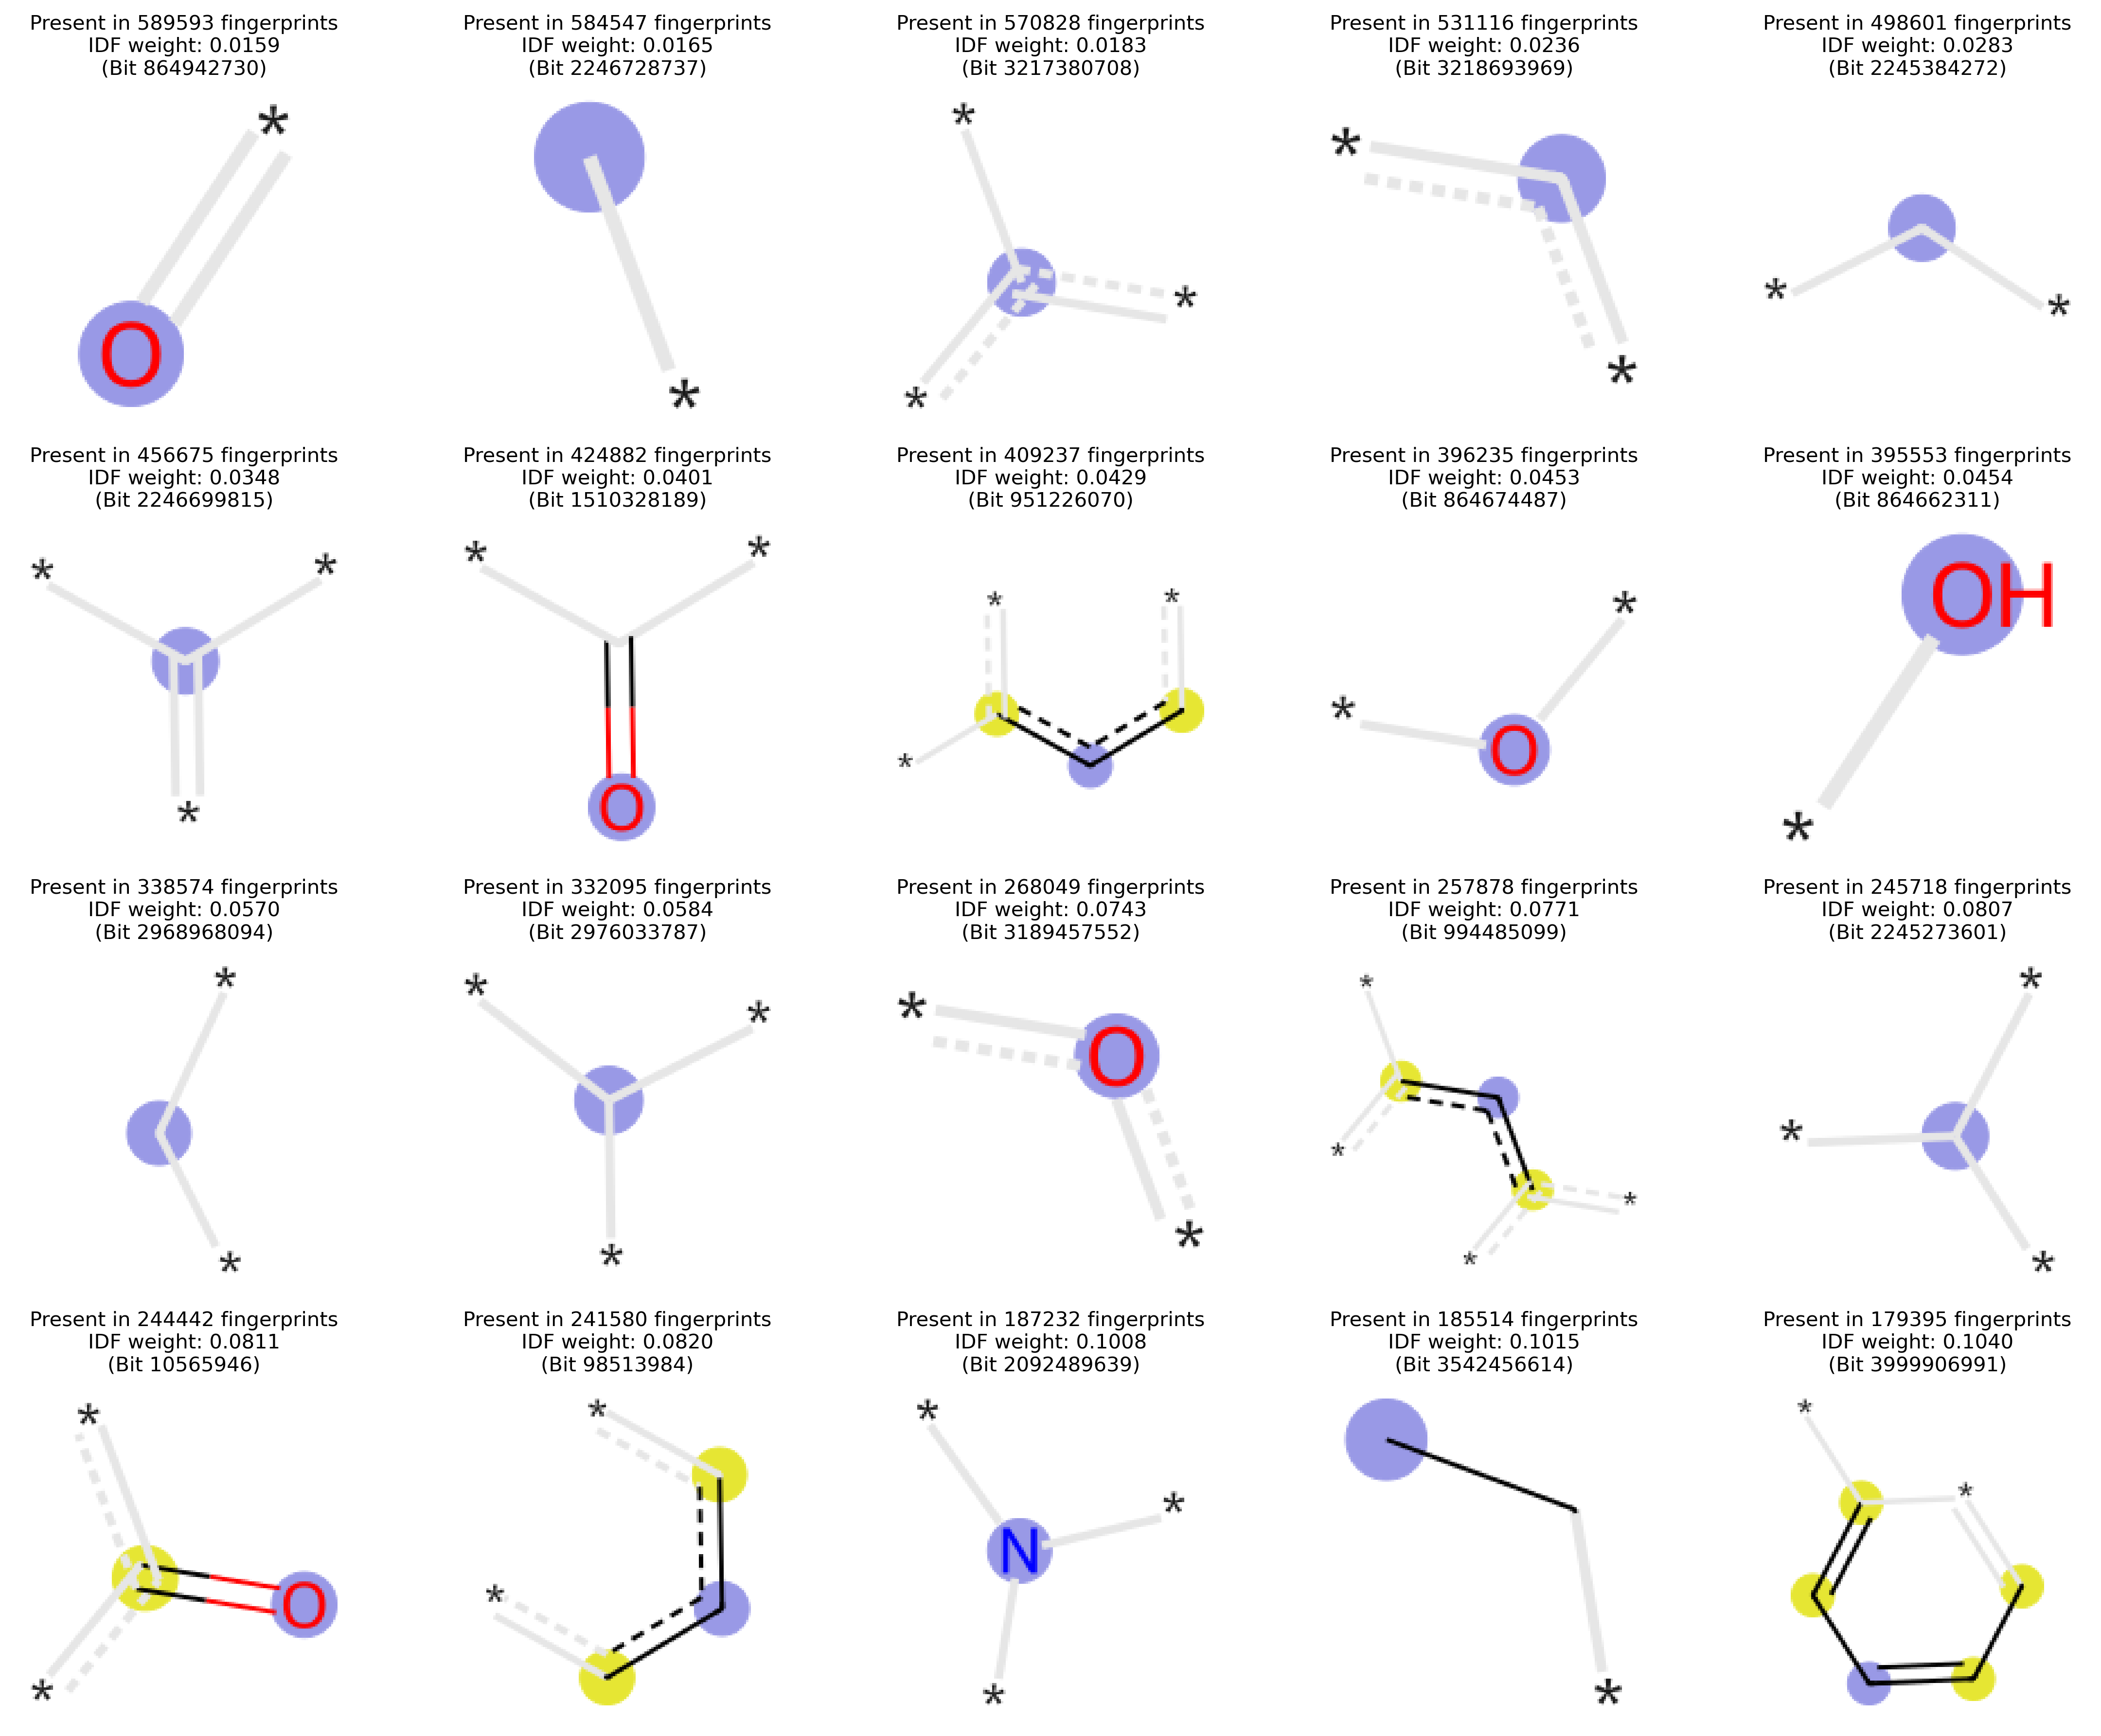

In [64]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import AllChem
import pandas as pd

# Assuming `unique_keys`, `idx_sorted`, `counts`, `compounds`, `fingerprints`, and helper functions are already defined
fpgen = AllChem.GetMorganGenerator(radius=3)

# Initialize data storage for frequent bits
frequent_bits = {
    "counts": [],
    "radius": [],
    "subsmiles": [],
    "bit_id": [],
    "mol_images": [],
}
mol_svgs = []
images = []

idx_sorted = np.argsort(counts)[::-1]


# Process top 20 bits
for i, idx in enumerate(idx_sorted[:20]):
    smiles = compounds.smiles[first_instances[idx]]
    mol = Chem.MolFromSmiles(smiles)

    ao = AllChem.AdditionalOutput()
    ao.CollectBitInfoMap()
    fp = fpgen.GetSparseCountFingerprint(mol, additionalOutput=ao)
    bi = ao.GetBitInfoMap()

    if unique_keys[idx] in bi:
        atom_idx, radius = bi[unique_keys[idx]][0]
        frequent_bits["counts"].append(counts[idx])
        frequent_bits["radius"].append(radius)
        frequent_bits["bit_id"].append(unique_keys[idx])
        
        # Generate substructure SMILES
        if radius == 0:
            subsmiles0 = get_substructure_smiles(mol, atom_idx, 0)
            subsmiles1 = get_substructure_smiles(mol, atom_idx, 1)
            frequent_bits["subsmiles"].append(subsmiles0 + " <-- " + subsmiles1)
        else:
            frequent_bits["subsmiles"].append(get_substructure_smiles(mol, atom_idx, radius))

        # Generate image of molecule with highlighted bit
        img = Draw.DrawMorganBit(mol, unique_keys[idx], bi)#, useSVG=True)
        images.append((mol, unique_keys[idx], bi))
        frequent_bits["mol_images"].append(img)
        #mol_svgs.append(img)

# Convert data to DataFrame
frequent_bits_df = pd.DataFrame(frequent_bits)
frequent_bits_df["idf_weight"] = idf_normalized(frequent_bits_df["counts"], len(fingerprints_morgan3_biostructures))

# Create grid plot
n_cols = 5
n_rows = (len(frequent_bits_df) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3), dpi=300)

legends = []

for i, ax in enumerate(axes.flatten()):
    if i < len(frequent_bits_df):
        ax.imshow(frequent_bits_df.loc[i, "mol_images"])
        legend = f"Present in {frequent_bits_df.loc[i, 'counts']} fingerprints\nIDF weight: {frequent_bits_df.loc[i, 'idf_weight']:.4f}\n(Bit {frequent_bits_df.loc[i, 'bit_id']})"
        legends.append(legend)
        ax.set_title(legend, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.savefig("most_frequent_bits_Morgan3_biostructures.png", dpi=450)
plt.show()

## Morgan-9

In [65]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=9, fpSize=4096)

fingerprints_morgan9_biostructures = compute_fingerprints_from_smiles(
    compounds.smiles, fpgen, count=False, sparse=True, progress_bar=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 730464/730464 [03:44<00:00, 3256.04it/s]


In [66]:
%%time

unique_keys, counts, first_instances = count_fingerprint_keys(fingerprints_morgan9_biostructures)#, max_keys=10**8)

CPU times: user 12.5 s, sys: 414 ms, total: 12.9 s
Wall time: 12.9 s


In [67]:
unique_keys.shape, counts.shape, first_instances.shape, counts.max()

((12576995,), (12576995,), (12576995,), np.int32(589593))

In [68]:
idx = np.where(counts > 1)[0]

pd.DataFrame({
    "bit": unique_keys[idx],
    "count": counts[idx],
    "first_instance": first_instances[idx]
}).to_csv("bit_counts_biostructures_morgan9_w_first_instance.csv")

In [69]:
num_compounds = len(fingerprints_morgan9_biostructures)

idx = np.where(counts > 1)[0]
bit_weighing = {unique_keys[i]: idf_normalized(counts[i], num_compounds) for i in idx}

In [70]:
pd.DataFrame({
    "bit": list(bit_weighing.keys()),
    "idf_weighing": list(bit_weighing.values())
}).set_index("bit").to_csv("bit_weighing_biostructures_morgan9.csv")

In [71]:
(counts == 1).sum()

np.int64(8733724)

## Use bit counts for idf-scaling of bits

In [62]:
unique_keys[:10], unique_keys[-10:]

(array([  368,   676,  1040,  1301,  4370,  4404,  7655,  8269,  9403,
        13347]),
 array([4294947328, 4294948502, 4294949385, 4294952990, 4294953238,
        4294957949, 4294958106, 4294963861, 4294964945, 4294967264]))

In [ ]:
def idf_normalized(df, N):
    def formula(x, N):
        return np.log(N / x)
    max_idf = formula(1, N)
    return formula(df, N) / max_idf

In [55]:
num_compounds = len(fingerprints_morgan3_biostructures)

idx = np.where(counts > 1)[0]
bit_weighing = {unique_keys[i]: idf_normalized(counts[i], num_compounds) for i in idx}

In [64]:
bit_weighing[864942730]

np.float64(0.015994633239014514)

In [71]:
pd.DataFrame({
    "bit": list(bit_weighing.keys()),
    "idf_weighing": list(bit_weighing.values())
}).set_index("bit").to_csv("bit_weighing_biostructures_morgan3.csv")

In [65]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=4096)

fingerprints_morgan3_sparse = compute_fingerprints_from_smiles(
    compounds.smiles[:1000], fpgen, count=True, sparse=True, progress_bar=True, bit_weighing=bit_weighing
)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4513.24it/s]


In [67]:
fingerprints_morgan3_sparse[1]

(array([  93585016,  102492624,  194855659,  422715066,  445431883,
         498730307,  548743766,  573169829,  584823634,  589930590,
         708370251,  730049667,  788839801,  847336149,  847961216,
         864674487,  864942730,  941282395,  950023157,  951226070,
         994485099, 1013267280, 1016841875, 1081231276, 1135286194,
        1143528820, 1266193593, 1310068516, 1490549211, 1510328189,
        1517662977, 1571432276, 1595673428, 1714831564, 1761951119,
        1788699751, 1844294411, 2050509910, 2077658817, 2115476908,
        2132058917, 2180786472, 2245273601, 2245384272, 2246340824,
        2246699815, 2246703798, 2246728737, 2309124039, 2424973678,
        2458968089, 2492789883, 2594220197, 2650699036, 2677858541,
        2713535913, 2788540332, 2827868305, 2829714342, 2931695851,
        2931878080, 2956998777, 3011598321, 3056593145, 3058180405,
        3060172001, 3079735252, 3088822697, 3112905891, 3207567135,
        3217380708, 3218693969, 3315826729, 3347

## Compare IDFs /counts between datasets

In [31]:
bit_weighing_ms2structures = pd.read_csv("bit_weighing_ms2structures_morgan3.csv")
bit_weighing_biostructures = pd.read_csv("bit_weighing_biostructures_morgan3.csv")


In [32]:
bit_weighing_ms2structures.head()

,bit,idf_weighing
0,34552,0.895732
1,59974,0.895732
2,79728,0.815316
3,93098,0.934214
4,96188,0.815316


In [33]:
bit_weighing_biostructures.head()

,bit,idf_weighing
0,368,0.829240
1,676,0.897192
2,1040,0.948596
3,9403,0.948596
4,13347,0.867123


In [35]:
bit_weighing_ms2structures.shape, bit_weighing_biostructures.shape

((111855, 2), (982548, 2))

In [38]:
overlap = np.intersect1d(bit_weighing_biostructures.bit.values,
                     bit_weighing_ms2structures.bit.values)

In [39]:
overlap.shape

(101905,)

In [40]:
overlap[:10]

array([ 34552,  59974,  79728,  93098,  96188, 115440, 150310, 154415,
       179532, 180552])

In [41]:
bit_weighing_ms2structures = bit_weighing_ms2structures.set_index("bit")
bit_weighing_biostructures = bit_weighing_biostructures.set_index("bit")

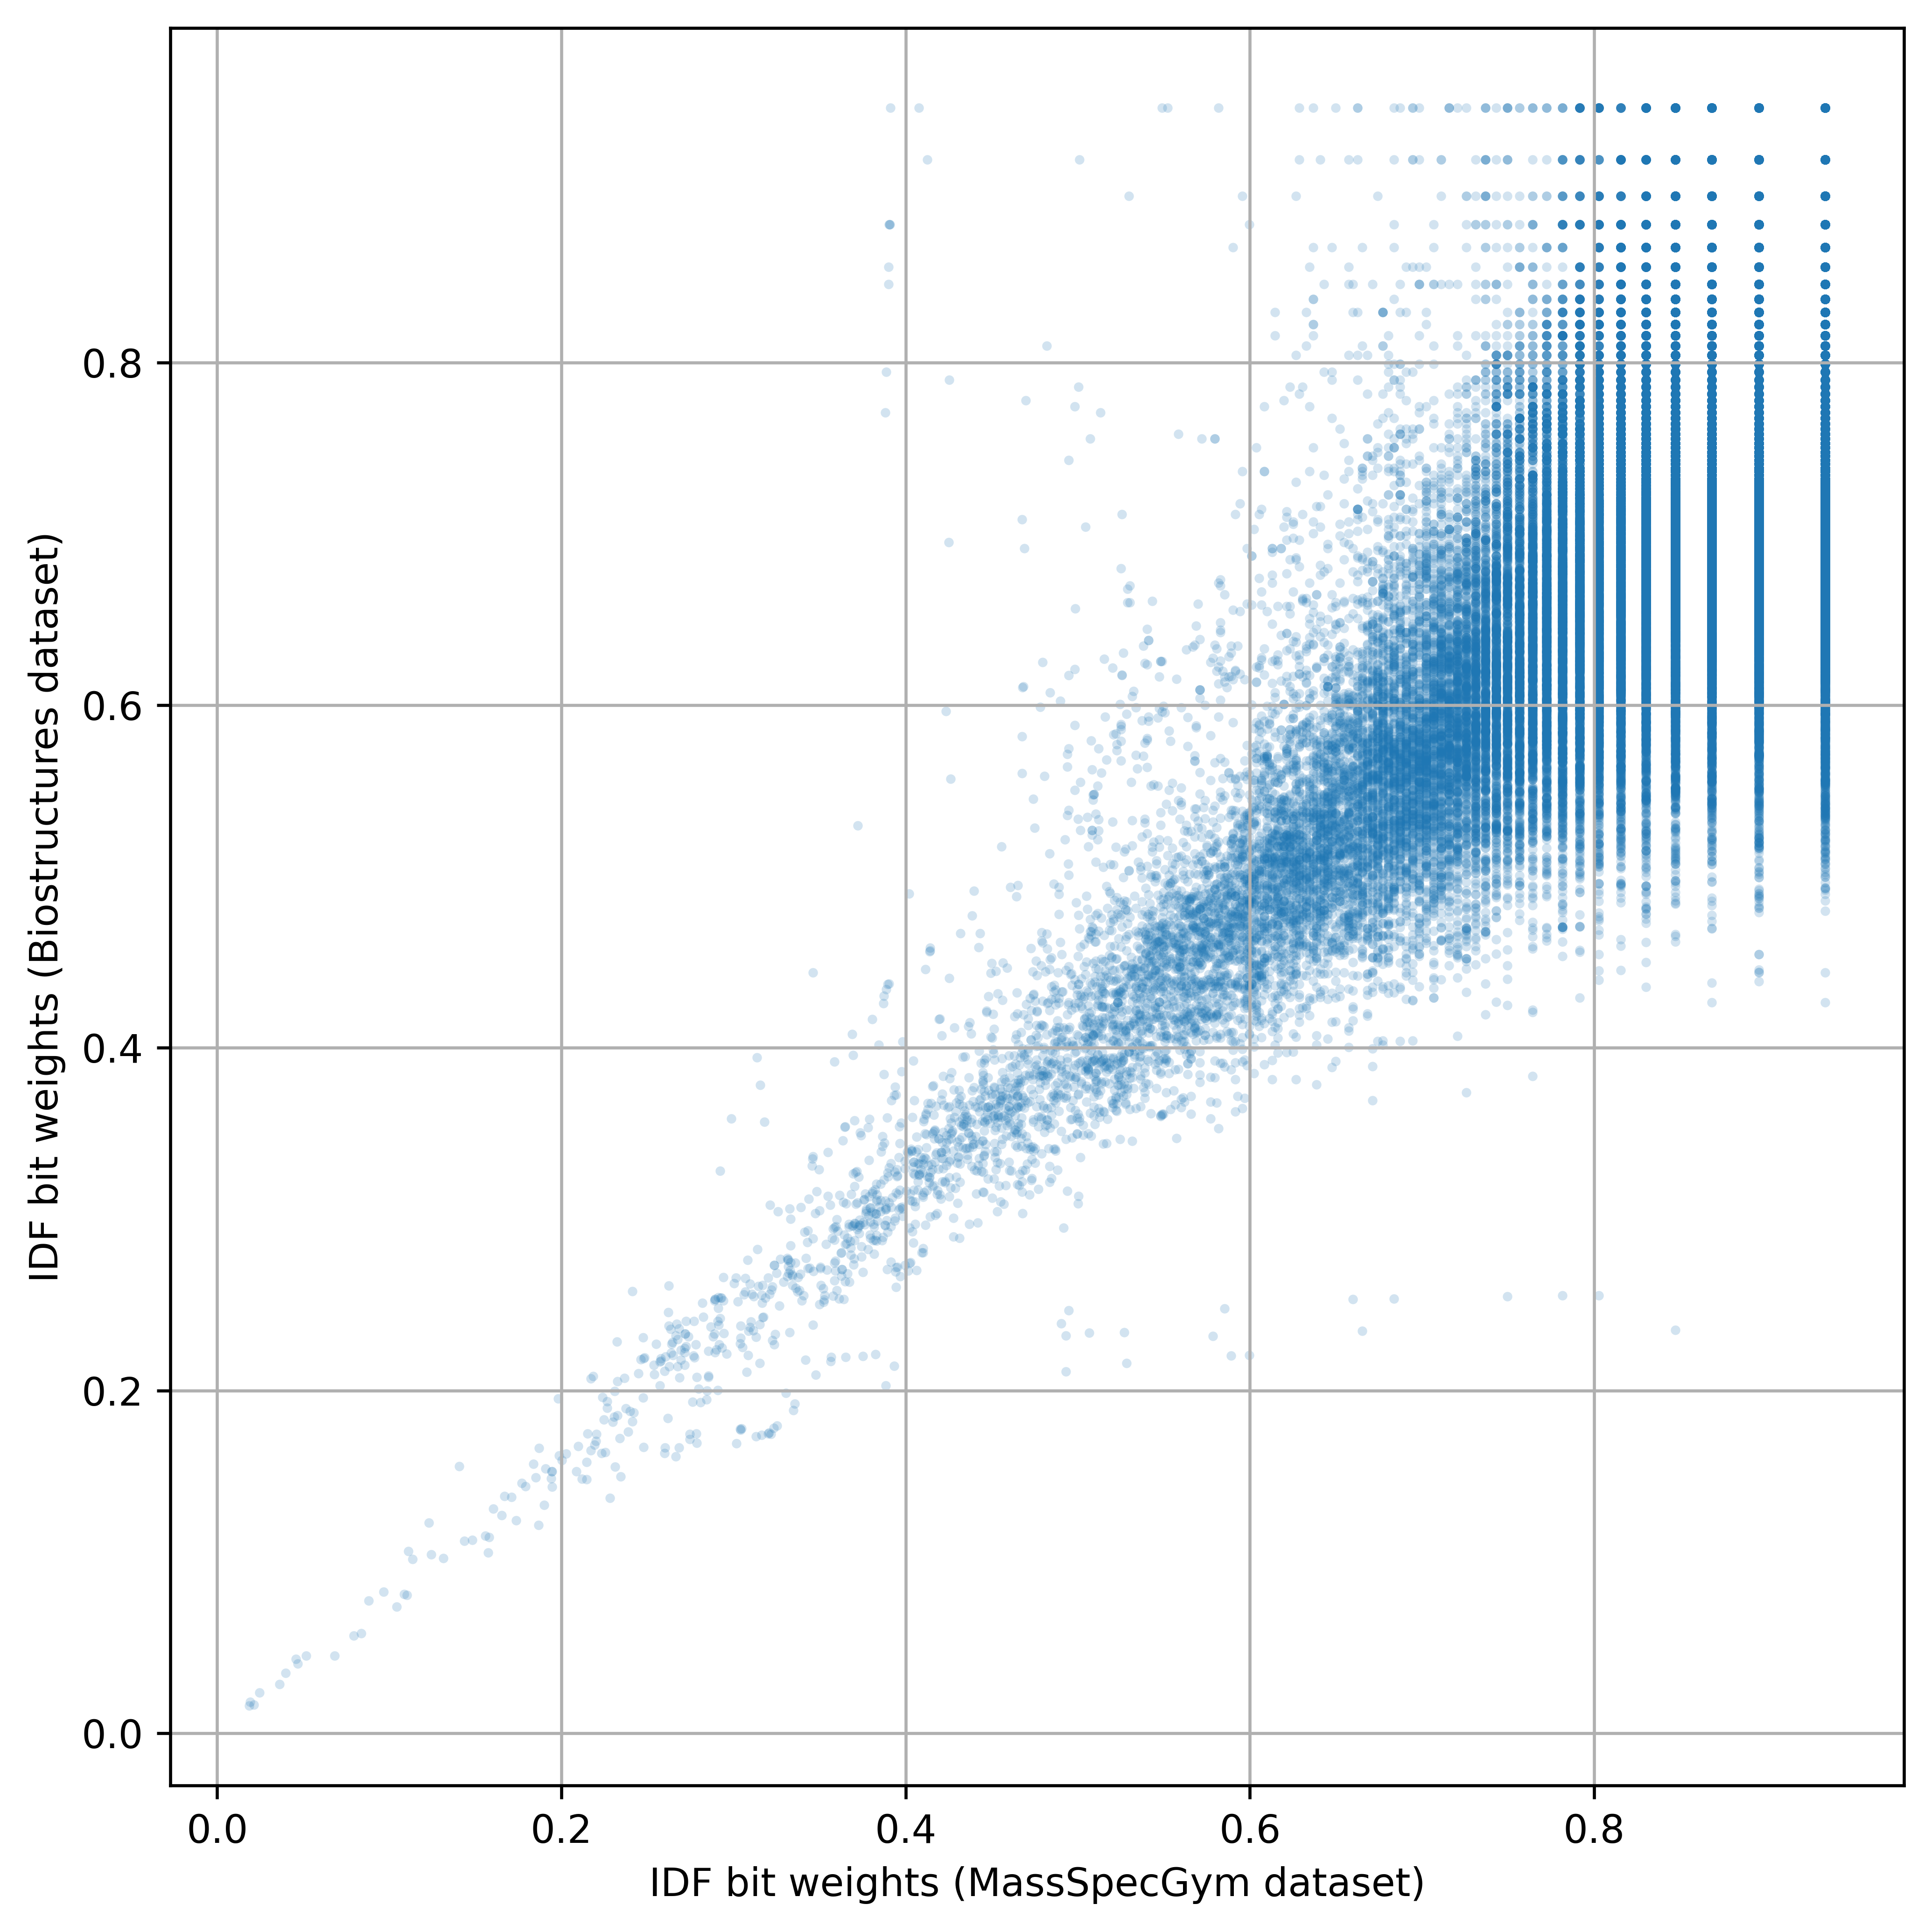

In [58]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=600)

ax.scatter(bit_weighing_ms2structures.loc[overlap],
           bit_weighing_biostructures.loc[overlap], s=6, alpha=0.2,
           linewidth=0,
          )

ax.set_xlabel("IDF bit weights (ms2structures dataset)")
ax.set_ylabel("IDF bit weights (Biostructures dataset)")
ax.grid(True)

plt.tight_layout()
plt.savefig("fig_scatter_plot_idf_weights.png", dpi=600)

In [59]:
from scipy import stats

res = stats.pearsonr(
    bit_weighing_ms2structures.loc[overlap],
    bit_weighing_biostructures.loc[overlap]
)
res

PearsonRResult(statistic=array([0.74994958]), pvalue=array([0.]))

In [62]:
diff1 = np.setdiff1d(
    bit_weighing_biostructures.index.values,
    bit_weighing_ms2structures.index.values)

diff1.shape

(880643,)

In [70]:
bit_weighing_biostructures.loc[diff1].describe()

,idf_weighing
count,880643.000000
mean,0.889371
std,0.069020
min,0.335518
25%,0.855691
50%,0.918527
75%,0.948596
max,0.948596


In [65]:
diff2 = np.setdiff1d(
    bit_weighing_ms2structures.index.values,
    bit_weighing_biostructures.index.values,
    )

diff2.shape

(9950,)

In [68]:
bit_weighing_ms2structures.loc[diff2].describe()

,idf_weighing
count,9950.000000
mean,0.904976
std,0.056365
min,0.501018
25%,0.895732
50%,0.934214
75%,0.934214
max,0.934214


In [72]:
(bit_weighing_ms2structures.loc[diff2] < 0.6).sum()

idf_weighing    51
dtype: int64